In [1]:
import keras
from keras import backend as K
from keras.layers import Dense, Input
import numpy as np
import tensorflow as tf
import math
import h5py
import random
import time
import pandas as pd
from context import * # imports MDN
import matplotlib.pyplot as plt
%matplotlib inline

input_colour = 'darkblue'
gen_colour = 'firebrick'
plt.style.use('seaborn-talk')

Using TensorFlow backend.


In [2]:
# Set up environment.
# Only for GPU use:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

## Helper functions for touchscreen performances

We need a few helper functions for managing performances:
    
- Convert performances to and from pandas dataframes.
- Generate random touches.
- Sample whole performances from scratch and from a priming performance.
- Plot performances including dividing into swipes.

# Load up the Dataset:

The dataset consists of around 1000 5-second performances from the MicroJam app.

This is in a sequence of points consisting of an x-location, a y-location, and a time-delta from the previous point.

When the user swipes, the time-delta is very small, if they tap it's quite large.

Let's have a look at some of the data:

Loaded perfs: 1626 and 1626
Num touches: 249870


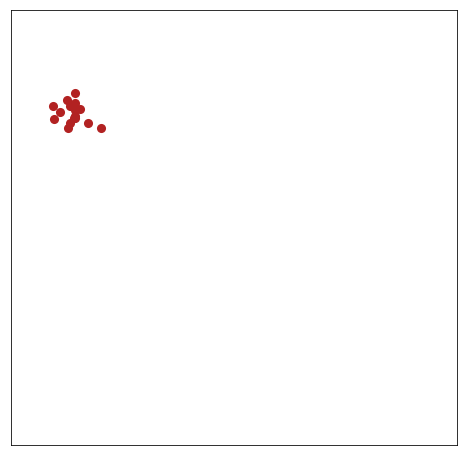

In [14]:
### Test Loading from the saved datafile.
with np.load('../datasets/tiny_performance_datasets.npz') as loaded:
    loaded_raw = loaded['raw_perfs']
    loaded_diff = loaded['diff_perfs']
    
print("Loaded perfs:", len(loaded_raw), "and", len(loaded_diff))
print("Num touches:", np.sum([len(l) for l in loaded_raw]))

corpus = []

for l in loaded_raw:
    corpus.append(l[:,:-1])
    
    
# Plot a bit of the data to have a look:
robojam.plot_2D(robojam.perf_array_to_df(random.choice(corpus)))

# Setup RNN and Training Data

In [ ]:
# Model Hyperparameters
SEQ_LEN = 30
HIDDEN_UNITS = 512
N_LAYERS = 2
NUMBER_MIXTURES = 5
TIME_DIST = True

# Training Hyperparameters:
BATCH_SIZE = 64
EPOCHS = 100
VAL_SPLIT=0.10

# Set random seed for reproducibility
SEED = 2345  
random.seed(SEED)
np.random.seed(SEED)

def batch_generator(seq_len, batch_size, dim, corpus):
    # Create empty arrays to contain batch of features and labels#
    batch_X = np.zeros((batch_size, seq_len, dim))
    batch_y = np.zeros((batch_size, dim))
    while True:
        for i in range(batch_size):
            # choose random example
            l = random.choice(corpus)
            last_index = len(l) - seq_len - 1
            start_index = np.random.randint(0, high=last_index)
            batch_X[i] = l[start_index:start_index+seq_len]
            batch_y[i] = l[start_index+1:start_index+seq_len+1] #.reshape(1,dim)
        yield batch_X, batch_y    

# Restrict corpus to sequences longer than the corpus.
corpus = [l for l in corpus if len(l) > SEQ_LEN+1]
print("Corpus Examples:", len(corpus))
# Produce the generator for training
generator = batch_generator(SEQ_LEN, BATCH_SIZE, 3, corpus)

# Functions for slicing up data
def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_overlapping_format(examples):
    """Takes sequences of seq_len+1 and returns overlapping
    sequences of seq_len."""
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[1:])
    return (xs,ys)

# Prepare training data as X and Y.
slices = []
for seq in corpus:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)
X, y = seq_to_overlapping_format(slices)

X = np.array(X) * SCALE_FACTOR
y = np.array(y) * SCALE_FACTOR

print("Number of training examples:")
print("X:", X.shape)
print("y:", y.shape)

## Training

In [ ]:
# Setup Training Model
model = build_robojam_model(seq_len=SEQ_LEN, hidden_units=HIDDEN_UNITS, num_mixtures=NUMBER_MIXTURES, layers=2, time_dist=TIME_DIST, inference=False, compile_model=True, print_summary=True)


# Setup callbacks
filepath="robojam-model" + "-layers" + str(N_LAYERS) + "-units" + str(HIDDEN_UNITS) + "-mixtures" + str(NUMBER_MIXTURES) + "-scale" + str(SCALE_FACTOR) + "-E{epoch:02d}-VL{val_loss:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
terminateOnNaN = keras.callbacks.TerminateOnNaN()
tboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=2, batch_size=32, write_graph=True, update_freq='epoch')

# Train
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT, callbacks=[checkpoint,terminateOnNaN, tboard])
#history = model.fit_generator(generator, steps_per_epoch=300, epochs=100, verbose=1, initial_epoch=0)

# Save final Model
#model.save('robojam-model-final.hdf5')  # creates a HDF5 file of the model

# Plot the loss
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Try out the model

- Let's try out the model
- First we will load up a decoding model with a sequence length of 1.
- The weights are loaded from a the trained model file.

In [106]:
# Decoding Model

# Model Hyperparameters
SEQ_LEN = 1
HIDDEN_UNITS = 512
N_LAYERS = 2
NUMBER_MIXTURES = 5
TIME_DIST = False


decoder = robojam.build_robojam_model(seq_len=SEQ_LEN, hidden_units=HIDDEN_UNITS, num_mixtures=NUMBER_MIXTURES, layers=N_LAYERS, time_dist=TIME_DIST, inference=True, compile_model=False, print_summary=True)
#decoder.load_weights("../robojam-model-layers2-units512-mixtures5-scale10-E13-VL-5.79.hdf5")
decoder.load_weights("../robojam-metatone-layers2-units512-mixtures5-scale10-E30-VL-5.65.hdf5")




Building RoboJam Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (1, 1, 3)                 0         
_________________________________________________________________
lstm0 (LSTM)                 (1, 1, 512)               1056768   
_________________________________________________________________
lstm1 (LSTM)                 (1, 512)                  2099200   
_________________________________________________________________
mdn_outputs (MDN)            (1, 35)                   17955     
Total params: 3,173,923
Trainable params: 3,173,923
Non-trainable params: 0
_________________________________________________________________


Plotting some conditioned performances.

This model seems to work best with a very low temperature (0.1). Might be able to do better with a large dataset, or larger model! (?)

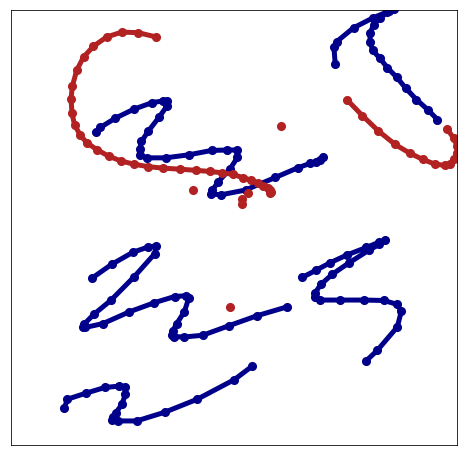

In [79]:
length = 100
# t = random.randint(0,len(microjam_corpus)-length)
t = 1000
mixture_temp = 1.5
sigma_temp = 0.01
ex =  random.choice(corpus) #microjam_corpus[t:t+length]  #sequences[600] 

decoder.reset_states()
p = robojam.condition_and_generate(decoder, ex, NUMBER_MIXTURES, temp=mixture_temp, sigma_temp=sigma_temp)
robojam.plot_double_2d(robojam.perf_array_to_df(ex), robojam.perf_array_to_df(p))

We can also generate unconditioned performances from a random starting point.

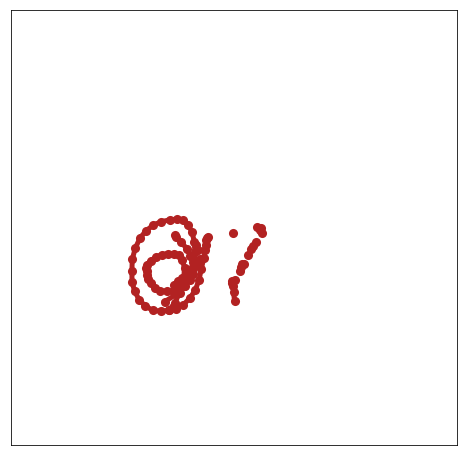

AttributeError: module 'robojam' has no attribute 'plot_3D'

In [115]:
decoder.reset_states()
mixture_temp = 1.5
sigma_temp = 0.01
t = robojam.random_touch()
p = robojam.generate_random_tiny_performance(decoder, NUMBER_MIXTURES, t, temp=mixture_temp, sigma_temp=sigma_temp)
robojam.plot_2D(robojam.perf_array_to_df(p))

robojam.plot_3D(robojam.perf_array_to_df(p))